In [ ]:
from scipy.stats import nbinom
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Monte Carlo to estimate R effective for each dispersion param
NUM_SIMS = 10000

COVID_RO = 2.4

MAX_GENERARATIONS = 30 

MAX_GATHERING_SIZE = 5

def draw_binomial(k, limit=MAX_GATHERING_SIZE):
    mean = COVID_RO
    variance = mean + (mean**2)/k
    p = mean/variance
    n = mean**2 / (variance - mean)
    draw = nbinom.rvs(n=n,p=p)
    if (draw > limit): # limit superspreaders
        draw = limit 
    return draw

def compute_re(k, limit):
    secondary_infection_list = []
    for _ in range(NUM_SIMS):
        secondary_infection_list.append(draw_binomial(k, limit))
    R_effective = sum(secondary_infection_list) / len(secondary_infection_list)

    return R_effective

ks = [0.04,.2,.42,.7]
res = []

for k in ks:
    res.append(compute_re(k, MAX_GATHERING_SIZE))

In [ ]:
import scipy.optimize as sp

def compute_epidemic_size(r0, should_plot=False):
    def f(r_inf):
        return r_inf

    def g(r_inf, r_naught):
        return 1 - np.exp(-r_naught * r_inf)

    def h(r_inf, r0):
        return f(r_inf) - g(r_inf, r_naught=r0)

    x = np.linspace(0, 1, 25)

    f_vals = f(x)
    g_vals = g(x, r0)

    rinf = sp.fsolve(h, 1, r0)

    if (should_plot == True):
        plt.plot(x, f_vals, c = 'k')
        plt.plot(x, g_vals, c = 'r')
        plt.scatter(rinf, rinf)
        plt.xlabel("Rinf")
        plt.ylabel("Rinf")
        plt.title(r0)
        plt.show()
    return rinf

In [ ]:
for re in res:
    print(re)
    final_infected_proportion = compute_epidemic_size(re)  
    print("R-Effective: ",re, " Percent of population who will become infected at some point before the epidemic dies: ", final_infected_proportion * 100)

In [ ]:
def simulate(num_generations, k):
    num_drawn = draw_binomial(k)
    # prevent runaway condition
    if(num_generations > MAX_GENERARATIONS):
        return False

    # dies
    if (num_drawn == 0):
        return True
    
    # spawns new generations
    else:
        for _ in range(num_drawn):
            if not simulate(num_generations + 1, k):
                return False
        return True

In [ ]:
def prob_dies(k):
    # simulate many
    grows_large = 0
    for i in range(NUM_SIMS):
        res = simulate(0, k) # start at 0 generations of infected
        if res == False: # grows large
            grows_large += 1

    fraction_epidemic = grows_large/NUM_SIMS
    print(fraction_epidemic * 100, "% of simulations will become endemic")

In [ ]:
for k in ks:
    prob_dies(k)

In [ ]:
# simulate r-effectives for different event size limits
def plot_res_limits(k):
    limits = np.arange(0,51,1)
    re_list = []
    for limit in limits:
        re_list.append(compute_re(k, limit))
    plt.plot(limits,re_list)
    plt.xlabel("Max number of secondary infections")
    plt.ylabel("Re")
    plt.title(f"k:{k}")
    plt.show()

In [ ]:
for k in ks:
    plot_res_limits(k)

In [ ]:
mu = 2.4
k = 0.42
x_shade_start = 5 

r = k
p = k / (k + mu)
x = np.arange(0, 25)
pmf = nbinom.pmf(x, k, p)

plt.figure(figsize=(10, 5))
plt.bar(x, pmf, color='lightgray', edgecolor='black', label='Negative Binomial PMF')

x_shade = x[x >= x_shade_start]
pmf_shade = pmf[x >= x_shade_start]
plt.bar(x_shade, pmf_shade, color='red', edgecolor='black', alpha=0.5, label=f'Shaded k ≥ {x_shade_start}')

plt.xlabel('Number of secondary infections')
plt.ylabel('Probability')
plt.title('Probability of secondary infections : R0=2.4, k = 0.41')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# contact pattern - no restrictions
# student - student : 30
# student - teacher : 1
# teacher - student : 30
# teacher - teacher : 2
# 3 teachers
# 30 students

In [ ]:
secondary_inf_probabilities = [float(p) for p in pmf]

## Relating Max Secondary Contacts to Gathering Size Limit

divide R_e by p or c. GET 

$$R_e = \beta / \gamma$$

$$\beta = p \cdot c$$

$$P = [.16, .23, .30]$$

$$C = \text{secondary inf} / p$$

C is max number of contacts, or Max gathering size

In [ ]:
p_list = [.16, .23, .30]

In [ ]:
def relate_max_secondary_to_contacts(p, max_Re, secondary_probability_list):
    contact_num_list = []
    avg_num_contacts = 0
    for i in range(max_Re):
        num_contacts = i / p
        contact_num_list.append(num_contacts)

        avg_num_contacts += secondary_probability_list[i] * i

    return contact_num_list, avg_num_contacts

In [ ]:
contact_num_list, c = relate_max_secondary_to_contacts(p=0.23, max_Re=len(secondary_inf_probabilities), secondary_probability_list=secondary_inf_probabilities)

print(contact_num_list)

print("c=", c)

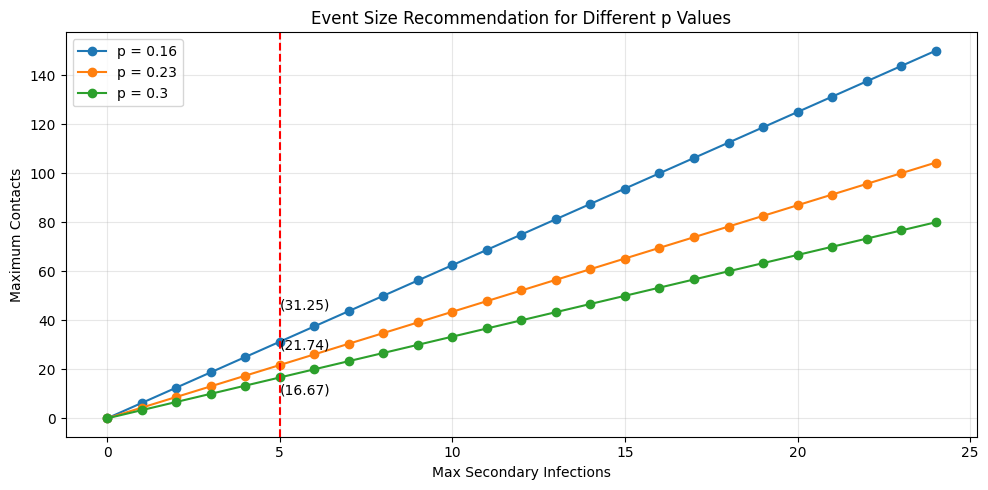

In [104]:
list_p16, _ = relate_max_secondary_to_contacts(p=0.16, max_Re=len(secondary_inf_probabilities), secondary_probability_list=secondary_inf_probabilities)
list_p23 = contact_num_list
list_p30, _ = relate_max_secondary_to_contacts(p=0.30, max_Re=len(secondary_inf_probabilities), secondary_probability_list=secondary_inf_probabilities)

p_list = [0.16, 0.23, 0.30]
lists = [list_p16, list_p23, list_p30]

plt.figure(figsize=(10, 5))

for p, values in zip(p_list, lists):
    plt.plot(values, marker='o', label=f"p = {p}")
    # Label the point at x=5
    if p == 0.16:
        plt.text(
            5,
            values[5] + 0.08 * max(values),   # small vertical offset
            f"({values[5]:.2f})",
            ha='left',
            va='bottom',
        )
    elif p == 0.23:
        plt.text(
            5,
            values[5] + 0.05 * max(values),   # small vertical offset
            f"({values[5]:.2f})",
            ha='left',
            va='bottom',
        )
    if p == 0.30:
        plt.text(
            5,
            values[5] - 0.1 * max(values),   # small vertical offset
            f"({values[5]:.2f})",
            ha='left',
            va='bottom',
        )

plt.axvline(5, color='red', linestyle='--')


plt.xlabel("Max Secondary Infections")
plt.ylabel("Maximum Contacts")
plt.title("Event Size Recommendation for Different p Values")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Set event size limit at 22 contacts for SIR comparison

In [ ]:
def SIR(S0,I0,R0, beta, gamma, t_max, stepsize):
    T = np.arange(0,t_max+stepsize,stepsize)
    S = np.zeros(len(T))
    I = np.zeros(len(T))
    R = np.zeros(len(T))
    N = S0+I0+R0
    
    for idx,t in enumerate(T):
        if idx==0:
            S[idx] = S0
            I[idx] = I0
            R[idx] = R0
        else:
            dS_dt = -beta * S[idx-1] * I[idx-1] / N
            dI_dt = beta * S[idx-1] * I[idx-1] / N - gamma * I[idx-1]
            dR_dt = gamma * I[idx-1]
            
            S[idx] = S[idx-1] + dS_dt * stepsize
            I[idx] = I[idx-1] + dI_dt * stepsize
            R[idx] = R[idx-1] + dR_dt * stepsize
    
    return S, I, R, T

In [ ]:
## SIR with no intervention
beta = c * p_list[1]

print(beta)

S,I,R,T = SIR(S0=999,I0=1,R0=0,
             beta=beta,
             gamma=1/13.4,
             t_max=50,
             stepsize=0.05)
fig, ax = plt.subplots()
ax.plot(T,S, color='b', label='Susceptibles')
ax.plot(T,I, color='r', label='Infecteds')
ax.plot(T,R, color='k', label='Recovereds')
ax.set_title('SIR With No Intervention')
ax.set_xlabel('time')
ax.set_ylabel('people')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

In [ ]:
## SIR with event size intervention (<5 secondary contacts = event size limit of 22)
_, c_restricted = relate_max_secondary_to_contacts(p_list[1], 6, secondary_inf_probabilities[:6])

beta = c_restricted * p_list[1]

print(beta)

S,I,R,T = SIR(S0=999,I0=1,R0=0,
             beta=beta,
             gamma=1/13.4,
             t_max=100,
             stepsize=0.05)
fig, ax = plt.subplots()
ax.plot(T,S, color='b', label='Susceptibles')
ax.plot(T,I, color='r', label='Infecteds')
ax.plot(T,R, color='k', label='Recovereds')
ax.set_title('SIR With Intervention')
ax.set_xlabel('time')
ax.set_ylabel('people')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)